# Validation of the Bipartite Network
https://bipartite-configuration-model.readthedocs.io/en/latest/

In [2]:
pip install bicm

  Using cached bicm-3.3.1-py3-none-any.whl.metadata (4.9 kB)
Using cached bicm-3.3.1-py3-none-any.whl (32 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
from scipy.sparse import csr_matrix
from bicm import BipartiteGraph

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import re

In [4]:
edge_list = pd.read_csv('../02_data/content_agnostic/train_edge_list.csv')
train_data = pd.read_csv('../02_data/content_agnostic/train_data.csv')

In [5]:
edge_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21158435 entries, 0 to 21158434
Data columns (total 2 columns):
 #   Column     Dtype
---  ------     -----
 0   chat_id    int64
 1   domain_id  int64
dtypes: int64(2)
memory usage: 322.9 MB


In [6]:
edge_list["domain_id"] = edge_list["domain_id"].astype(str).str.strip()
edge_list["domain_id"] = pd.to_numeric(edge_list["domain_id"], errors="coerce")
edge_list = edge_list.dropna()
edge_list = edge_list.astype(int)
edge_list = edge_list.reset_index(drop=True)

In [7]:
print('unique chats:', len(edge_list["chat_id"].unique()))
print('unique domains:', len(edge_list["domain_id"].unique()))

unique chats: 29051
unique domains: 5857


In [8]:
# extract unique row (chat) and column (domain) nodes
chat_nodes = sorted(edge_list['chat_id'].unique())   # Row nodes (layer True)
domain_nodes = sorted(edge_list['domain_id'].unique())  # Column nodes (layer False)

# index mapping for fast lookup
chat_to_idx = {chat: i for i, chat in enumerate(chat_nodes)}
domain_to_idx = {domain: i for i, domain in enumerate(domain_nodes)}

# row and column indices for the biadjacency matrix
row_indices = edge_list['chat_id'].map(chat_to_idx).to_numpy()
col_indices = edge_list['domain_id'].map(domain_to_idx).to_numpy()

# sparse biadjacency matrix (binary)
biadj_matrix = csr_matrix((np.ones(len(row_indices), dtype=int), (row_indices, col_indices)),
                          shape=(len(chat_nodes), len(domain_nodes)))

# dense NumPy array
biadj_matrix_dense = biadj_matrix.toarray()

print(f"Biadjacency Matrix Shape (Chats, Domains): {biadj_matrix.shape}")
print(biadj_matrix_dense[:10, :10]) 

Biadjacency Matrix Shape (Chats, Domains): (29051, 5857)
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [9]:
myGraph = BipartiteGraph()
myGraph.set_edgelist(edge_list.to_numpy())
#myGraph.set_biadjacency_matrix(biadj_matrix)
myGraph

In [10]:
temp = myGraph.get_cols_projection(alpha=0.05, method='poisson', threads_num=4, progress_bar=True, fmt='edgelist') # monopartite network of domains
# co-occurrences of domains in the same chat
# correcting the projection on statistical significance level of 95%

First I have to compute the BiCM. Computing...


/opt/conda/lib/python3.11/site-packages/numba/core/utils.py:554: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/opt/conda/lib/python3.11/site-packages/bicm/models_functions.py:326: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
/opt/conda/lib/python3.11/site-packages/bicm/models_functions.py:327: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]
/opt/conda/lib/python3.11/site-packages/numba/core/utils.py:554: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


max rows error = 9.227924238075502e-07
max columns error = 1.2750368114211597e-05
total error = 0.0010722013765998017
Solver converged.


100%|██████████| 5857/5857 [04:03<00:00, 24.10it/s]


In [13]:
my_probability_matrix = myGraph.get_bicm_matrix() 
my_x, my_y = myGraph.get_bicm_fitnesses()

In [14]:
my_probability_matrix

array([[4.05079118e-07, 6.73466082e-04, 2.47028878e-05, ...,
        2.02438333e-07, 2.02438333e-07, 4.29277381e-06],
       [6.87477472e-04, 5.33696351e-01, 4.02649283e-02, ...,
        3.43685069e-04, 3.43685069e-04, 7.23772778e-03],
       [5.06272601e-05, 7.76877704e-02, 3.07812294e-03, ...,
        2.53016144e-05, 2.53016144e-05, 5.36257396e-04],
       ...,
       [4.05079118e-07, 6.73466082e-04, 2.47028878e-05, ...,
        2.02438333e-07, 2.02438333e-07, 4.29277381e-06],
       [6.28099992e-05, 9.46145356e-02, 3.81604977e-03, ...,
        3.13902839e-05, 3.13902839e-05, 6.65222464e-04],
       [9.34620168e-06, 1.53111047e-02, 5.69652704e-04, ...,
        4.67078620e-06, 4.67078620e-06, 9.90366708e-05]])

In [15]:
temp.shape

(464690, 2)

In [16]:
temp

array([[6059, 6063],
       [6059, 6095],
       [6059, 6102],
       ...,
       [2219, 6491],
       [2219, 6529],
       [2219, 7368]])

In [17]:
W_uv = np.zeros((len(my_x), len(my_x)))
for x in temp:
    W_uv[x[0], x[1]] = 1
    W_uv[x[1], x[0]] = 1

In [18]:
W_uv.shape

(29051, 29051)

In [19]:
G_valid = nx.Graph()
G_valid.add_edges_from(temp)
pc1_dict = dict(zip(train_data["domain_id"], train_data["pc1"]))
nx.set_node_attributes(G_valid, pc1_dict, "pc1")

In [20]:
# Compute node degrees
degree_dict = dict(G_valid.degree())

Top 50% degree threshold: 89.0
Filtered nodes count: 2675
Subgraph node count: 2675
Size of node_colors array: 2675


/opt/conda/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


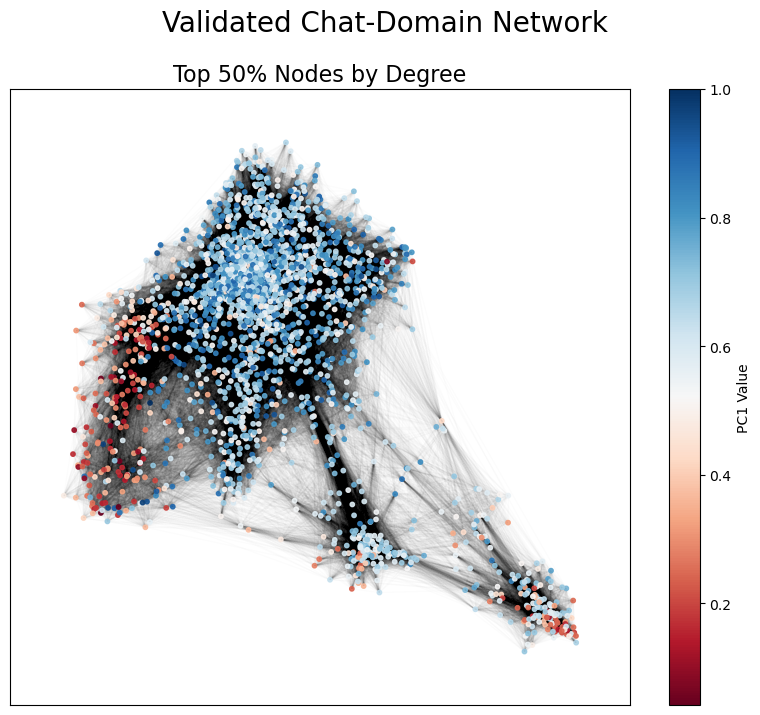

In [21]:
G_valid = nx.Graph()
G_valid.add_edges_from(temp)
pc1_dict = dict(zip(train_data["domain_id"], train_data["pc1"]))
nx.set_node_attributes(G_valid, pc1_dict, "pc1")

# node degrees
degree_dict = dict(G_valid.degree())

# degree threshold
degree_threshold = np.percentile(list(degree_dict.values()), 50)
filtered_nodes = [node for node, deg in degree_dict.items() if deg >= degree_threshold]

# debugging
print(f"Top 50% degree threshold: {degree_threshold}")
print(f"Filtered nodes count: {len(filtered_nodes)}")

# subgraph
subgraph = G_valid.subgraph(filtered_nodes)

# Extract PC1 values for all nodes in the subgraph
pc1_values = np.array([pc1_dict.get(node, 0) for node in subgraph.nodes()])

# colors
norm = plt.Normalize(vmin=min(pc1_values), vmax=max(pc1_values))
cmap = plt.cm.RdBu
node_colors = cmap(norm(pc1_values))

print(f"Subgraph node count: {len(subgraph.nodes())}")
print(f"Size of node_colors array: {len(node_colors)}")

# network plot
fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.spring_layout(subgraph, k=0.01, seed=42)

nodes = nx.draw_networkx_nodes(subgraph, pos, node_size=10, alpha=0.9, node_color=node_colors, cmap=cmap, ax=ax)
nx.draw_networkx_edges(subgraph, pos, alpha=0.01, ax=ax)

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work
fig.colorbar(sm, ax=ax, label="PC1 Value")

plt.suptitle("Validated Chat-Domain Network", fontsize=20)
plt.title("Top 50% Nodes by Degree", fontsize=16)

# plt.title("Projection of the bipartite network of chats and domains (Top 25% Nodes by Degree, Colored by PC1)")
plt.savefig('../03_plots/degree_network_colored.png')
plt.show()


Subgraph node count: 5329
Size of node_colors array: 5329


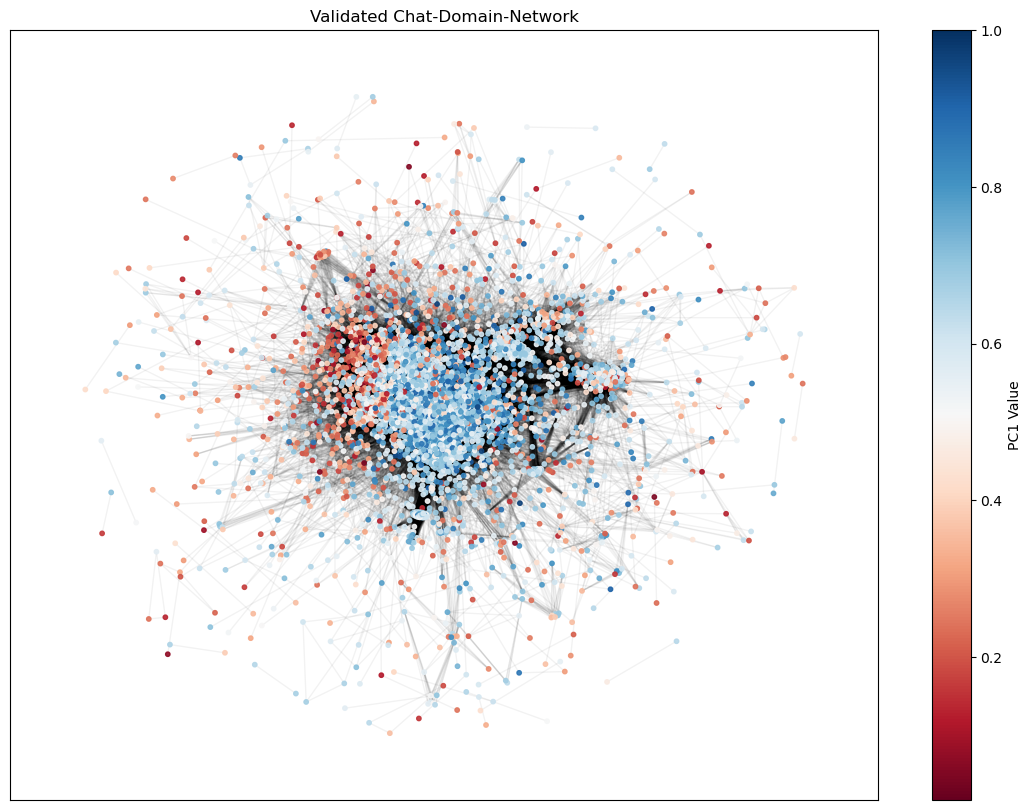

In [22]:
pc1_values = np.array([pc1_dict.get(node, 0) for node in G_valid.nodes()])

# Normalize colors
norm = plt.Normalize(vmin=min(pc1_values), vmax=max(pc1_values))
cmap = plt.cm.RdBu
node_colors = cmap(norm(pc1_values))

# Debugging: Ensure node_colors and subgraph size match
print(f"Subgraph node count: {len(G_valid.nodes())}")
print(f"Size of node_colors array: {len(node_colors)}")

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 10))

# Compute layout
pos = nx.spring_layout(G_valid, k=0.1, seed=42)

# Draw network plot
nodes = nx.draw_networkx_nodes(G_valid, pos, node_size=10, alpha=0.9, node_color=node_colors, cmap=cmap, ax=ax)
nx.draw_networkx_edges(G_valid, pos, alpha=0.05, ax=ax)

# Add colorbar properly linked to the figure
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work
fig.colorbar(sm, ax=ax, label="PC1 Value")

# Add title and save
plt.title("Validated Chat-Domain-Network")
plt.savefig('../03_plots/degree_network_colored.png')
plt.show()

In [23]:
np.save("../02_data/content_agnostic/validated_edges.npy", temp)
np.save("../02_data/content_agnostic/validated_adjecency_matrix.npy", W_uv)